In [12]:
# --- Cell 0: Versions, seeds, GPU, (optional) mixed precision ---
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
np.random.seed(42); tf.random.set_seed(42)

print(f"TensorFlow: {tf.__version__}")
print("GPU:", tf.config.list_physical_devices('GPU'))

# Recommended on recent NVIDIA GPUs; harmless if not available
try:
    from tensorflow.keras.mixed_precision import set_global_policy
    set_global_policy("mixed_float16")
    print("Mixed precision: enabled")
except Exception as e:
    print("Mixed precision not enabled:", e)

import gc, tensorflow as tf
from tensorflow import keras
try:
    keras.backend.clear_session()
except Exception:
    pass
gc.collect()

# (Optional: avoid Python workers ballooning RAM)
tf.config.threading.set_inter_op_parallelism_threads(2)
tf.config.threading.set_intra_op_parallelism_threads(2)



TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mixed precision: enabled


In [13]:
# --- Cell 1: Mount Drive (same as your pipeline) ---
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# --- Cell 2: Dataset paths & quick sanity checks (same structure) ---
base_dir = "/content/drive/MyDrive/Images/Images"
appendicitis_path     = os.path.join(base_dir, "Appendicitis_Images")
no_appendicitis_path  = os.path.join(base_dir, "No_Appendicitis_Images")

print("Appendicitis path:", appendicitis_path, "| exists:", os.path.isdir(appendicitis_path))
print("No Appendicitis path:", no_appendicitis_path, "| exists:", os.path.isdir(no_appendicitis_path))

def count_images(p):
    if not os.path.isdir(p): return 0
    exts = (".bmp",".jpg",".jpeg",".png")
    return sum(f.lower().endswith(exts) for f in os.listdir(p))

print("Found appendicitis images:", count_images(appendicitis_path))
print("Found no-appendicitis images:", count_images(no_appendicitis_path))


Appendicitis path: /content/drive/MyDrive/Images/Images/Appendicitis_Images | exists: True
No Appendicitis path: /content/drive/MyDrive/Images/Images/No_Appendicitis_Images | exists: True
Found appendicitis images: 1340
Found no-appendicitis images: 382


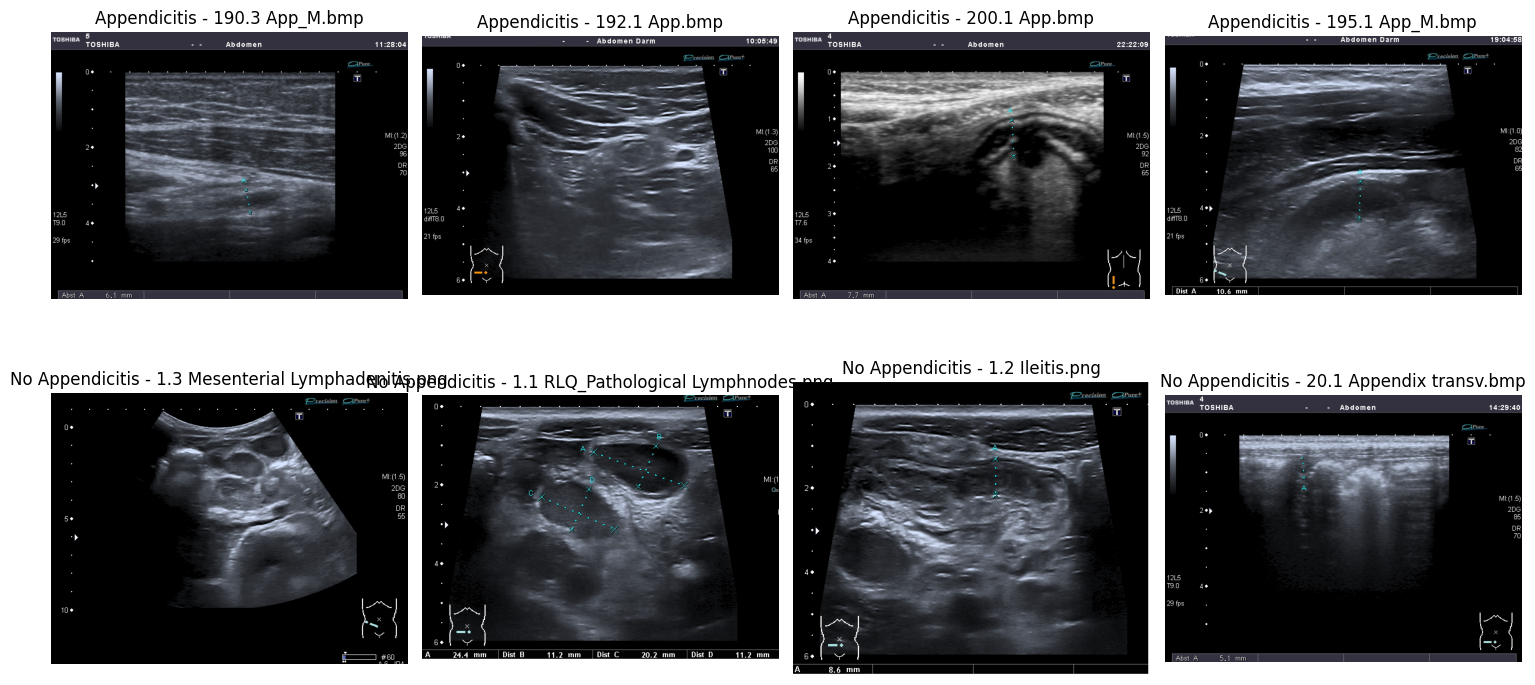

In [15]:
# --- Cell 3: (Optional) peek at a few samples (same as before) ---
def plot_sample_images(num_samples=4):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
    for row, (p, title) in enumerate([(appendicitis_path,"Appendicitis"), (no_appendicitis_path,"No Appendicitis")]):
        files = [f for f in os.listdir(p) if f.lower().endswith(('.bmp','.jpg','.jpeg','.png'))][:num_samples]
        for i, fname in enumerate(files):
            img = Image.open(os.path.join(p, fname))
            axes[row, i].imshow(img, cmap='gray')
            axes[row, i].set_title(f'{title} - {fname}')
            axes[row, i].axis('off')
    plt.tight_layout(); plt.show()

plot_sample_images()


In [16]:
# === New Cell 4: List files + stratified split (paths only; no image arrays) ===
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

base_dir = "/content/drive/MyDrive/Images/Images"
appendicitis_path     = os.path.join(base_dir, "Appendicitis_Images")
no_appendicitis_path  = os.path.join(base_dir, "No_Appendicitis_Images")

EXTS = ("*.bmp","*.jpg","*.jpeg","*.png")
def all_files(folder):
    files = []
    for pat in EXTS:
        files.extend(glob.glob(os.path.join(folder, pat)))
    return sorted(files)

pos_files = all_files(appendicitis_path)   # label 1
neg_files = all_files(no_appendicitis_path) # label 0

files = np.array(pos_files + neg_files, dtype=object)
labels = np.array([1]*len(pos_files) + [0]*len(neg_files), dtype=np.int32)

# Stratified split: 70/15/15
X_train, X_temp, y_train, y_temp = train_test_split(files, labels, test_size=0.30, stratify=labels, random_state=42)
X_val,   X_test, y_val,  y_test  = train_test_split(X_temp, y_temp,  test_size=0.50, stratify=y_temp, random_state=42)

print(f"Train:{len(X_train)}  Val:{len(X_val)}  Test:{len(X_test)}")
print("Train dist:", np.bincount(y_train), "| Val dist:", np.bincount(y_val), "| Test dist:", np.bincount(y_test))


Train:1205  Val:258  Test:259
Train dist: [267 938] | Val dist: [ 57 201] | Test dist: [ 58 201]


In [17]:
# === Helper: tf.data pipeline from file paths ===
import tensorflow as tf
IMG_SIZE = (300, 300)   # or (456,456) if you want faster training
BATCH_SIZE_P1 = 2

def _load_image(path, label, img_size):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, img_size, method=tf.image.ResizeMethod.BILINEAR)
    img = tf.cast(img, tf.float32)  # 0..255, model preprocess runs later

    # Make y shape = (1,) so the batch becomes (batch, 1)
    label = tf.expand_dims(tf.cast(label, tf.float32), -1)
    return img, label


def make_ds(files, labels, training, batch_size, img_size=None, shuffle=True):
    if img_size is None:
        img_size = IMG_SIZE
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    if training and shuffle:
        ds = ds.shuffle(buffer_size=len(files), reshuffle_each_iteration=True)
    ds = ds.map(lambda f,l: _load_image(f, l, img_size), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


In [18]:
# === New Cell 5B: UNDERSAMPLE majority class for TRAIN ONLY ===
import numpy as np

# Check original train distribution
counts = np.bincount(y_train)
print("Original train distribution [class 0, class 1]:", counts.tolist())

# Split by class
X_train_0 = X_train[y_train == 0]  # class 0 paths
X_train_1 = X_train[y_train == 1]  # class 1 paths
n0, n1 = len(X_train_0), len(X_train_1)

# Identify majority & minority sizes
rng = np.random.default_rng(42)
if n0 > n1:
    # class 0 is majority → downsample class 0 to n1
    idx = rng.choice(n0, size=n1, replace=False)
    X_major_ds = X_train_0[idx]
    X_minor_all = X_train_1
    y_major_ds = np.zeros(n1, dtype=np.int32)
    y_minor_all = np.ones(n1,  dtype=np.int32)
else:
    # class 1 is majority → downsample class 1 to n0
    idx = rng.choice(n1, size=n0, replace=False)
    X_major_ds = X_train_1[idx]
    X_minor_all = X_train_0
    y_major_ds = np.ones(n0,  dtype=np.int32)
    y_minor_all = np.zeros(n0, dtype=np.int32)

# Build balanced (undersampled) arrays
X_train_bal = np.concatenate([X_major_ds, X_minor_all], axis=0)
y_train_bal = np.concatenate([y_major_ds, y_minor_all], axis=0)

# Shuffle in unison
perm = rng.permutation(len(X_train_bal))
X_train_bal = X_train_bal[perm]
y_train_bal = y_train_bal[perm]

print("UNDERSAMPLED train distribution [class 0, class 1]:", np.bincount(y_train_bal).tolist())

# Important: keep downstream variable names the same so later cells don't change
X_train_os = X_train_bal
y_train_os = y_train_bal

# Build datasets: undersampled train, same val/test
train_ds = make_ds(X_train_os, y_train_os, training=True,  batch_size=BATCH_SIZE_P1)
val_ds   = make_ds(X_val,      y_val,      training=False, batch_size=max(2, BATCH_SIZE_P1))
test_ds  = make_ds(X_test,     y_test,     training=False, batch_size=max(2, BATCH_SIZE_P1))


Original train distribution [class 0, class 1]: [267, 938]
UNDERSAMPLED train distribution [class 0, class 1]: [267, 267]


In [19]:
# === Cell 6: Build model with only preprocess (NO augmentation) ===
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input

def build_model(img_size=IMG_SIZE):
    inputs = layers.Input(shape=img_size + (3,), name="input")
    # No data_augmentation here
    x = layers.Lambda(preprocess_input, name="preprocess")(inputs)

    base = EfficientNetB7(include_top=False, weights="imagenet", input_tensor=x)
    base.trainable = False  # Phase 1: freeze

    x = layers.GlobalAveragePooling2D(name="gap")(base.output)
    x = layers.BatchNormalization(name="bn_head")(x)
    x = layers.Dense(512, activation="relu", name="dense_512")(x)
    x = layers.Dropout(0.5, name="drop_50")(x)
    x = layers.Dense(256, activation="relu", name="dense_256")(x)
    x = layers.Dropout(0.3, name="drop_30")(x)
    outputs = layers.Dense(1, activation="sigmoid", dtype="float32", name="pred")(x)
    return keras.Model(inputs, outputs, name="appendicitis_efficientnetb7_no_aug")

model = build_model()
model.summary()


Model: "appendicitis_efficientnetb7_no_aug"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 300, 300,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocess (Lambda) │ (None, 300, 300,  │          0 │ input[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ preprocess[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati

 Total params: 65,550,744 (250.06 MB)

 Trainable params: 1,447,937 (5.52 MB)

 Non-trainable params: 64,102,807 (244.53 MB)

In [20]:
# --- Cell 7: Compile Phase 1 (head-only) ---
# Keras 3 F1 metric
from keras.metrics import F1Score

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        F1Score(name="f1", threshold=0.5, average="micro"),
    ],
)


In [21]:
# --- Cell 8: Callbacks (same style; monitor val_loss + val_accuracy) ---
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

callbacks_phase1 = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1),
    ModelCheckpoint('best_efficientnetb7_phase1.keras', monitor='val_accuracy', mode='max',
                    save_best_only=True, verbose=1)
]


In [22]:
# --- Cell 8: Callbacks stay the same (ReduceLROnPlateau + ModelCheckpoint) ---

print("Starting Phase 1 (frozen backbone) with Undersampled train_ds (no augmentation, no class weights)...")
history_phase1 = model.fit(
    train_ds,            # <-- Undersampled dataset from Cell 5B
    epochs=20,
    validation_data=val_ds,
    callbacks=callbacks_phase1,
    verbose=1
)


Starting Phase 1 (frozen backbone) with Undersampled train_ds (no augmentation, no class weights)...
Epoch 1/20
266/267 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5415 - f1: 0.4964 - loss: 1.5873 - precision: 0.5337 - recall: 0.4719
Epoch 1: val_accuracy improved from -inf to 0.49225, saving model to best_efficientnetb7_phase1.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 129s 186ms/step - accuracy: 0.5412 - f1: 0.4965 - loss: 1.5881 - precision: 0.5335 - recall: 0.4722 - val_accuracy: 0.4922 - val_f1: 0.5677 - val_loss: 0.8232 - val_precision: 0.8431 - val_recall: 0.4279 - learning_rate: 0.0010
Epoch 2/20
266/267 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5365 - f1: 0.4798 - loss: 1.1201 - precision: 0.5067 - recall: 0.4579
Epoch 2: val_accuracy improved from 0.49225 to 0.71705, saving model to best_efficientnetb7_phase1.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - accuracy: 0.5366 - f1: 0.4802 - loss: 1.1195 - precision: 0.5070 - recall: 0.4584 - val_accuracy: 0.7171 - val_f1: 0

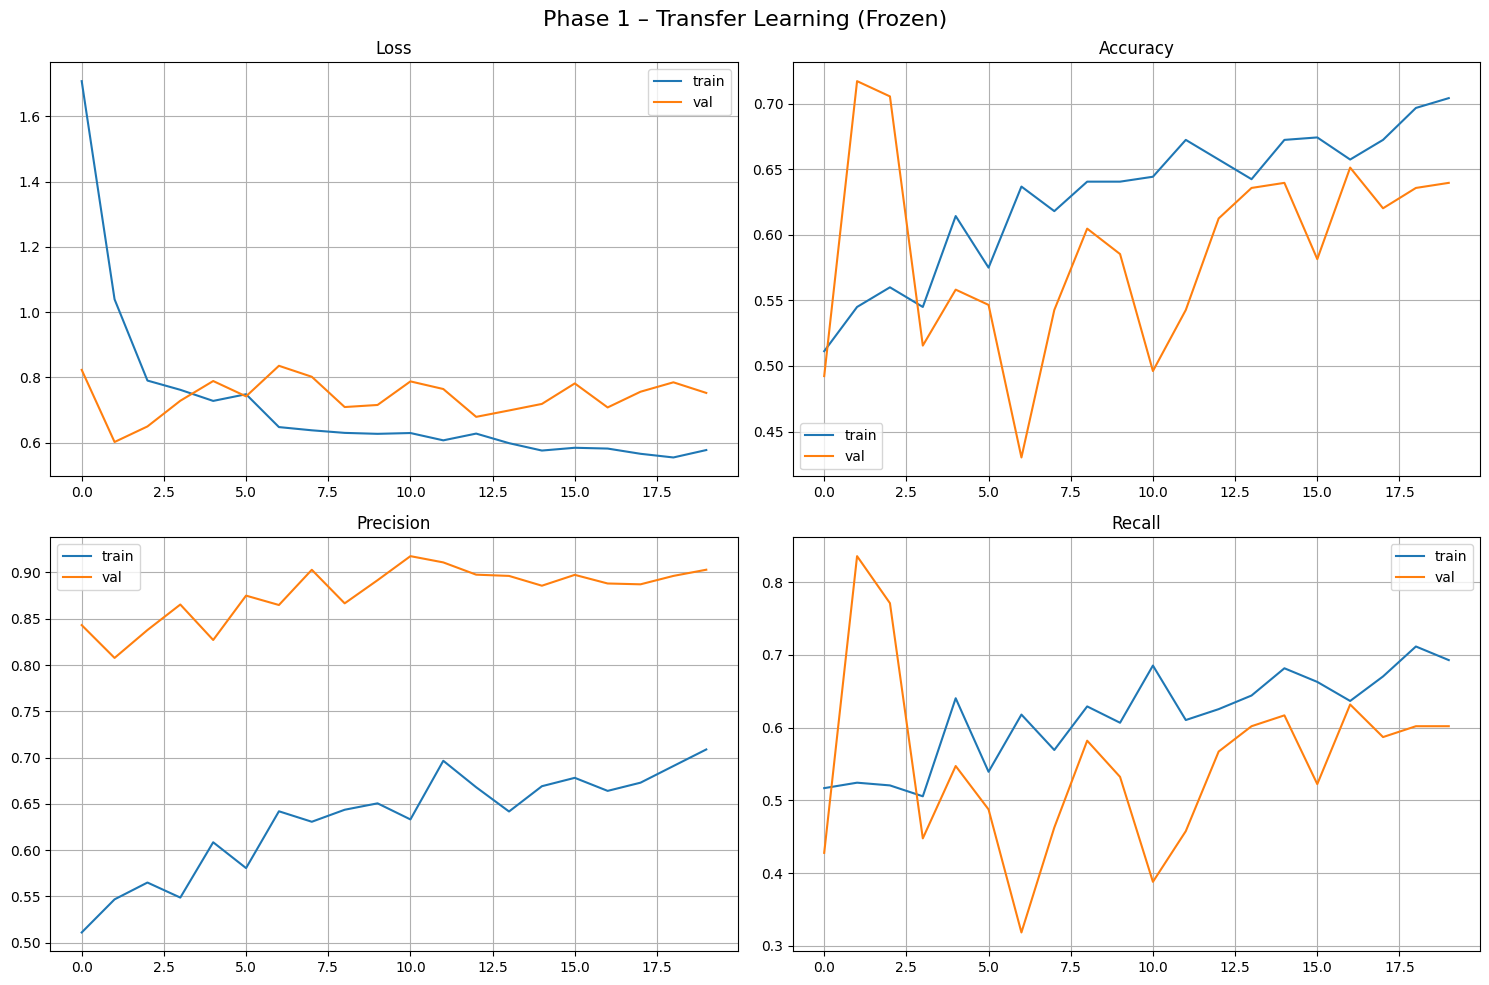

In [23]:
# --- Cell 10: Plot Phase 1 history (same style) ---
def plot_history(h, title="History"):
    fig, axes = plt.subplots(2, 2, figsize=(15,10))
    fig.suptitle(title, fontsize=16)

    axes[0,0].plot(h.history['loss']); axes[0,0].plot(h.history['val_loss'])
    axes[0,0].set_title('Loss'); axes[0,0].legend(['train','val']); axes[0,0].grid(True)

    axes[0,1].plot(h.history['accuracy']); axes[0,1].plot(h.history['val_accuracy'])
    axes[0,1].set_title('Accuracy'); axes[0,1].legend(['train','val']); axes[0,1].grid(True)

    axes[1,0].plot(h.history['precision']); axes[1,0].plot(h.history['val_precision'])
    axes[1,0].set_title('Precision'); axes[1,0].legend(['train','val']); axes[1,0].grid(True)

    axes[1,1].plot(h.history['recall']); axes[1,1].plot(h.history['val_recall'])
    axes[1,1].set_title('Recall'); axes[1,1].legend(['train','val']); axes[1,1].grid(True)

    plt.tight_layout(); plt.show()

plot_history(history_phase1, "Phase 1 – Transfer Learning (Frozen)")


Validation Classification Report (Phase 1):
                 precision    recall  f1-score   support

No Appendicitis       0.35      0.77      0.49        57
   Appendicitis       0.90      0.60      0.72       201

       accuracy                           0.64       258
      macro avg       0.63      0.69      0.60       258
   weighted avg       0.78      0.64      0.67       258



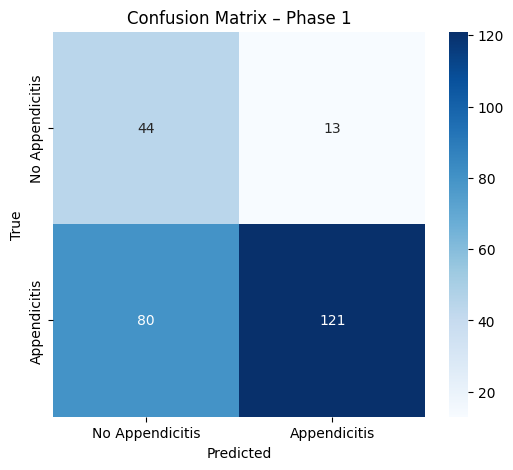

In [24]:
# --- Cell 11: Phase 1 validation report (dataset-based) ---
from sklearn.metrics import classification_report, confusion_matrix

val_prob = model.predict(val_ds, verbose=0).ravel()
val_pred = (val_prob > 0.5).astype(int)

print("Validation Classification Report (Phase 1):")
print(classification_report(y_val, val_pred,
                            target_names=['No Appendicitis', 'Appendicitis']))

cm = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Appendicitis','Appendicitis'],
            yticklabels=['No Appendicitis','Appendicitis'])
plt.title('Confusion Matrix – Phase 1'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()


In [28]:
# === Cell 12: Load best Phase-1 weights & selectively unfreeze tail ===
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization

# Try to load Phase-1 checkpoint (from your earlier ModelCheckpoint)
try:
    model.load_weights("best_efficientnetb7_phase1.keras")
    print("Loaded Phase-1 weights.")
except Exception as e:
    print("Warning: could not load Phase-1 checkpoint:", e)

def unfreeze_tail(model, unfreeze_last=200):
    """
    Freeze everything, then unfreeze the last `unfreeze_last`
    non-BatchNorm layers. All BatchNorm layers remain frozen.
    """
    for layer in model.layers:
        layer.trainable = False

    unfrozen = 0
    for layer in reversed(model.layers):
        if isinstance(layer, BatchNormalization):
            layer.trainable = False
            continue
        if unfrozen < unfreeze_last:
            layer.trainable = True
            unfrozen += 1
        else:
            break

    print(f"Unfroze {unfrozen} non-BN layers at the tail; kept BatchNorm frozen.")

UNFREEZE_LAST = 200  # adjust to 150–250 if needed
unfreeze_tail(model, unfreeze_last=UNFREEZE_LAST)


Loaded Phase-1 weights.
Unfroze 200 non-BN layers at the tail; kept BatchNorm frozen.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 242 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [29]:
# === Cell 13: Re-compile for fine-tuning (lower LR, same metrics) ===
import tensorflow as tf
from tensorflow import keras
from keras.metrics import F1Score
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

optimizer_ft = keras.optimizers.Adam(learning_rate=1e-5)
optimizer_ft.clipnorm = 1.0  # stabilizes FT on tiny batches

model.compile(
    optimizer=optimizer_ft,
    loss=keras.losses.BinaryCrossentropy(label_smoothing=0.02),
    metrics=[
        "accuracy",
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        F1Score(name="f1", threshold=0.5, average="micro"),
    ],
)

callbacks_phase2 = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint(
        "best_efficientnetb7_phase2.keras",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        verbose=1,
    ),
]

print("Model recompiled for fine-tuning.")


Model recompiled for fine-tuning.


In [30]:
# === Cell 14: Fine-tune using Undersampled train set (no class weights) ===

BATCH_SIZE_P2 = 2  # keep small for B7
train_ds_ft = make_ds(X_train_os, y_train_os, training=True,  batch_size=BATCH_SIZE_P2)
val_ds_ft   = make_ds(X_val,      y_val,      training=False, batch_size=max(2, BATCH_SIZE_P2))

EPOCHS_FT = 15  # adjust per curves

print("Starting Phase 2 (fine-tuning tail) with Undersampled train_ds_ft…")
history_phase2 = model.fit(
    train_ds_ft,
    epochs=EPOCHS_FT,
    validation_data=val_ds_ft,
    callbacks=callbacks_phase2,
    verbose=1
)

print("Fine-tuning complete. Best checkpoint at best_efficientnetb7_phase2.keras")


Starting Phase 2 (fine-tuning tail) with Undersampled train_ds_ft…
Epoch 1/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5523 - f1: 0.5604 - loss: 0.8245 - precision: 0.5528 - recall: 0.5724
Epoch 1: val_accuracy improved from -inf to 0.65116, saving model to best_efficientnetb7_phase2.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 190s 266ms/step - accuracy: 0.5524 - f1: 0.5605 - loss: 0.8245 - precision: 0.5529 - recall: 0.5724 - val_accuracy: 0.6512 - val_f1: 0.7429 - val_loss: 0.6696 - val_precision: 0.8725 - val_recall: 0.6468 - learning_rate: 1.0000e-05
Epoch 2/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6361 - f1: 0.6584 - loss: 0.8198 - precision: 0.6340 - recall: 0.6875
Epoch 2: val_accuracy did not improve from 0.65116
267/267 ━━━━━━━━━━━━━━━━━━━━ 32s 118ms/step - accuracy: 0.6361 - f1: 0.6584 - loss: 0.8197 - precision: 0.6340 - recall: 0.6876 - val_accuracy: 0.6318 - val_f1: 0.7130 - val_loss: 0.6931 - val_precision: 0.9077 - val_recall: 0.5871 - learning_ra

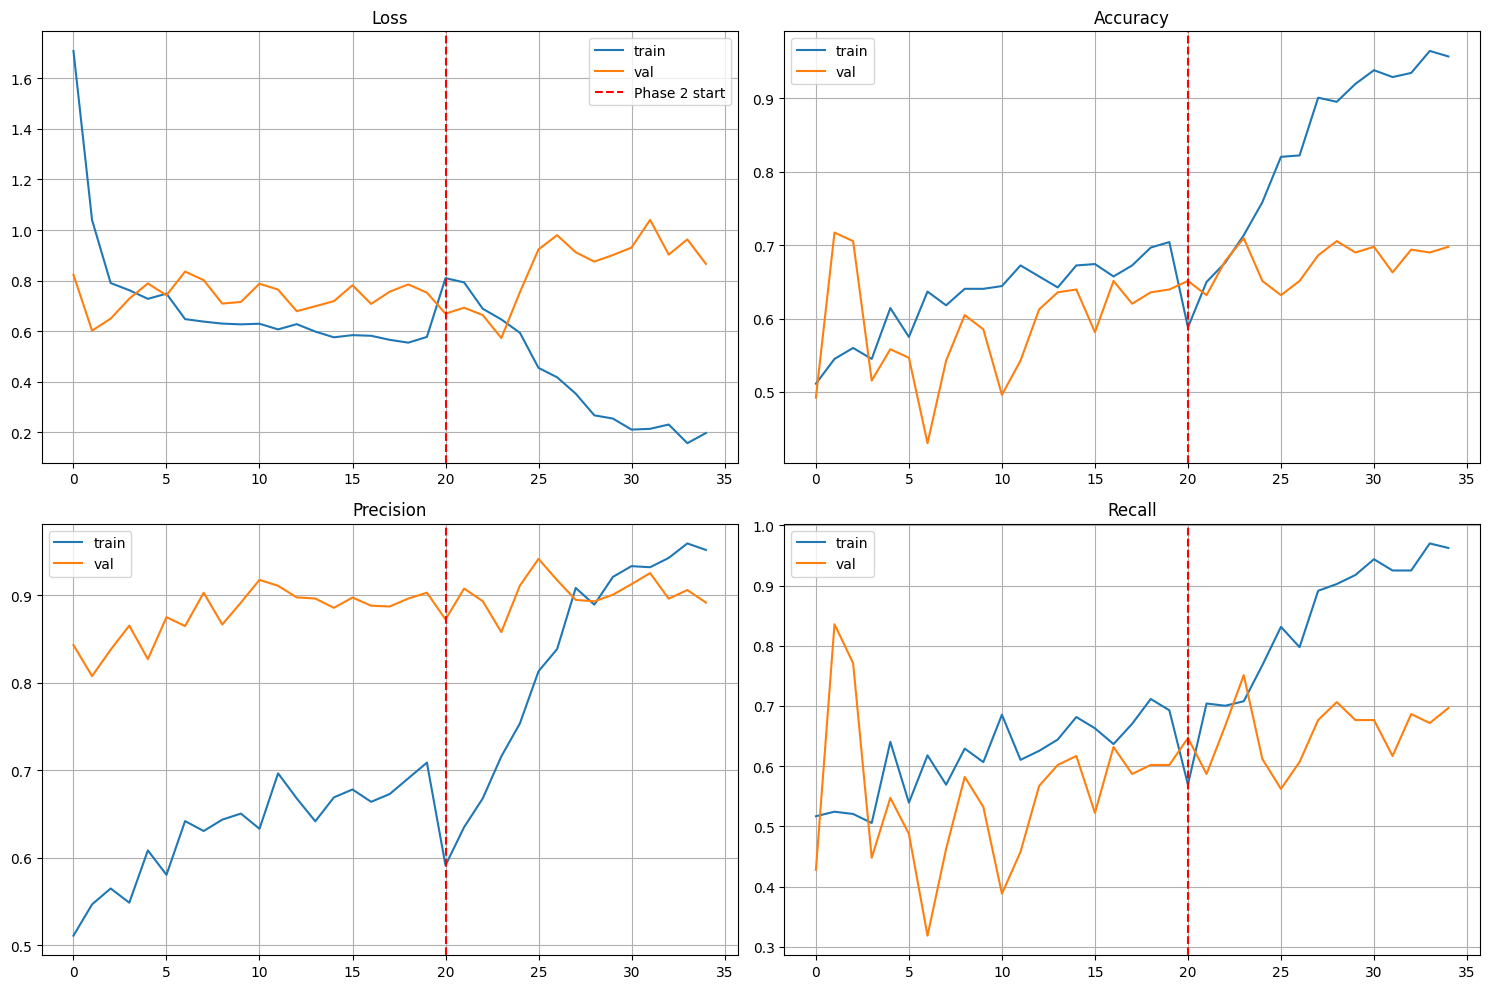

In [31]:
# --- Cell 15: Plot combined history (same style) ---
def plot_combined(h1, h2, split_label="FT start"):
    fig, axes = plt.subplots(2, 2, figsize=(15,10))
    p1 = len(h1.history['loss'])
    def join(k): return h1.history[k] + h2.history[k]

    axes[0,0].plot(join('loss')); axes[0,0].plot(join('val_loss'))
    axes[0,0].axvline(p1, color='red', ls='--', label=split_label)
    axes[0,0].set_title('Loss'); axes[0,0].legend(['train','val',split_label]); axes[0,0].grid(True)

    axes[0,1].plot(join('accuracy')); axes[0,1].plot(join('val_accuracy'))
    axes[0,1].axvline(p1, color='red', ls='--'); axes[0,1].set_title('Accuracy'); axes[0,1].legend(['train','val']); axes[0,1].grid(True)

    axes[1,0].plot(join('precision')); axes[1,0].plot(join('val_precision'))
    axes[1,0].axvline(p1, color='red', ls='--'); axes[1,0].set_title('Precision'); axes[1,0].legend(['train','val']); axes[1,0].grid(True)

    axes[1,1].plot(join('recall')); axes[1,1].plot(join('val_recall'))
    axes[1,1].axvline(p1, color='red', ls='--'); axes[1,1].set_title('Recall'); axes[1,1].legend(['train','val']); axes[1,1].grid(True)

    plt.tight_layout(); plt.show()

plot_combined(history_phase1, history_phase2, split_label="Phase 2 start")


Final Evaluation on Test Set:
Test Loss: 0.8492
Test Accuracy: 0.6988
Test Precision: 0.8639
Test Recall: 0.7264
Test F1 (Keras): 0.7892

Final Test Set Classification Report:
                 precision    recall  f1-score   support

No Appendicitis       0.39      0.60      0.47        58
   Appendicitis       0.86      0.73      0.79       201

       accuracy                           0.70       259
      macro avg       0.63      0.66      0.63       259
   weighted avg       0.76      0.70      0.72       259



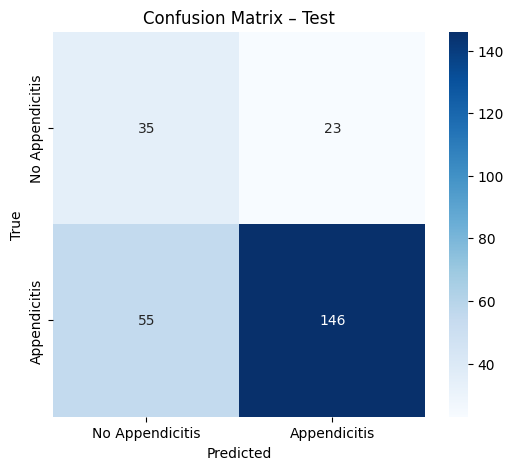

Sensitivity (Recall): 0.726 | Specificity: 0.603 | F1 (sklearn): 0.789
Balanced Accuracy: 0.665


In [32]:
# --- Cell 16: Final evaluation on Test set (dataset-based) ---
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print("Final Evaluation on Test Set:")
test_loss, test_acc, test_prec, test_rec, test_f1 = model.evaluate(test_ds, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1 (Keras): {test_f1:.4f}")

test_prob = model.predict(test_ds, verbose=0).ravel()
test_pred = (test_prob > 0.5).astype(int)

print("\nFinal Test Set Classification Report:")
print(classification_report(y_test, test_pred,
                            target_names=['No Appendicitis','Appendicitis']))

cm_test = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Appendicitis','Appendicitis'],
            yticklabels=['No Appendicitis','Appendicitis'])
plt.title('Confusion Matrix – Test'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

tn, fp, fn, tp = cm_test.ravel()
sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
f1_sklearn = f1_score(y_test, test_pred)
print(f"Sensitivity (Recall): {sens:.3f} | Specificity: {spec:.3f} | F1 (sklearn): {f1_sklearn:.3f}")
print(f"Balanced Accuracy: {(sens+spec)/2:.3f}")



Additional Evaluation Metrics:
Macro F1 Score: 0.6311
AUC (ROC): 0.7422


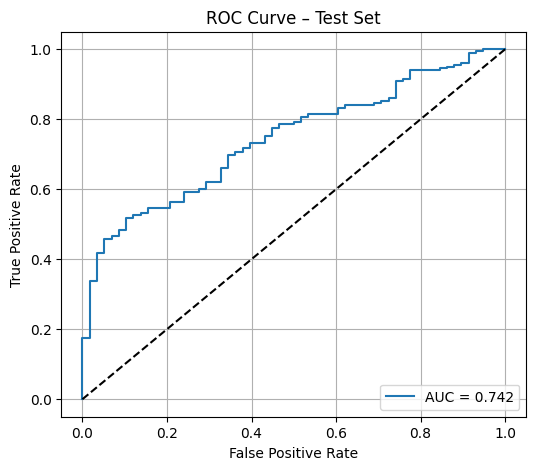

In [33]:
# === Additional Metrics: Macro F1 and AUC ===
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Ensure 1-D arrays
y_true = np.asarray(y_test).ravel()
y_prob = np.asarray(test_prob).ravel()     # probabilities from model.predict(test_ds)
y_pred = np.asarray(test_pred).ravel()     # hard labels (0/1)

# Macro-F1: equal weight to both classes
macro_f1 = f1_score(y_true, y_pred, average='macro')
# AUC: must use probabilities
auc = roc_auc_score(y_true, y_prob)

print("\nAdditional Evaluation Metrics:")
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"AUC (ROC): {auc:.4f}")

# ROC curve (optional)
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [34]:
# --- Cell 17: Save model + lightweight predict helper (updated for 600x600 + preprocess_input) ---
model.save('final_appendicitis_efficientnetb7_undersampling.keras')
print("Saved: final_appendicitis_efficientnetb7_undersampling.keras")

def predict_appendicitis(image_path, model_path='final_appendicitis_efficientnetb7_undersampling.keras', threshold=0.5):
    loaded = tf.keras.models.load_model(model_path)
    img = Image.open(image_path)
    if img.mode != 'RGB': img = img.convert('RGB')
    img = img.resize(IMG_SIZE)
    arr = np.array(img)                     # 0..255
    arr = np.expand_dims(arr, axis=0)       # [1,H,W,3]
    # replicate model-side preprocessing
    arr = tf.keras.applications.efficientnet.preprocess_input(arr)
    prob = float(loaded.predict(arr, verbose=0)[0][0])
    pred = int(prob > threshold)
    return {
        "image_path": image_path,
        "probability": prob,
        "prediction": "Appendicitis" if pred==1 else "No Appendicitis",
        "confidence": float(max(prob, 1-prob)),
        "threshold_used": threshold
    }

# Example (path must exist):
# result = predict_appendicitis("/content/drive/MyDrive/Images/Images/No_Appendicitis_Images/xxx.jpg")
# print(result)


Saved: final_appendicitis_efficientnetb7_undersampling.keras


In [35]:
import os, shutil

# === Define your model-specific subfolder ===
model_name = "EfficientNetB7_undersampling"  # 👈 change per experiment

# === Create the nested directory in Drive ===
save_dir = f"/content/drive/MyDrive/Appendicitis_Models/{model_name}"
os.makedirs(save_dir, exist_ok=True)

# === Copy your key files into that subfolder ===
for f in [
    "final_appendicitis_efficientnetb7_undersampling.keras",  # final model (saved above)
    "best_efficientnetb7_phase1.keras",                      # Phase 1 checkpoint
    "best_efficientnetb7_phase2.keras",                      # Phase 2 checkpoint
]:
    if os.path.exists(f):
        shutil.copy(f, save_dir)
        print(f"✅ Saved: {f} → {save_dir}")
    else:
        print(f"⚠️ File not found: {f}")

print(f"\nAll files safely stored in: {save_dir}")


✅ Saved: final_appendicitis_efficientnetb7_undersampling.keras → /content/drive/MyDrive/Appendicitis_Models/EfficientNetB7_undersampling
✅ Saved: best_efficientnetb7_phase1.keras → /content/drive/MyDrive/Appendicitis_Models/EfficientNetB7_undersampling
✅ Saved: best_efficientnetb7_phase2.keras → /content/drive/MyDrive/Appendicitis_Models/EfficientNetB7_undersampling

All files safely stored in: /content/drive/MyDrive/Appendicitis_Models/EfficientNetB7_undersampling
